# **The Bivariate Boxplot**
## **Introduction**
The boxplot is an excellent method for summarizing univariate data and identifying outliers. However, when we have multivariate data, using  individual boxplots is insufficient to understand our data. The reason for this is that individual boxplots do not take into account the relationship between variables. The bivariate boxplot is a boxplot extension that allows us to analyse two variables jointly. The bivariate boxplot, like the boxplot, is very useful for identifying outliers.

Bivariate boxplots are not implemented in Python, but they are in R. So, in order to perform this assignment in a Python environment, I will use the rpy2 package, which allows Python to call R functions.

The following sections are included in this document:
1. Required steps for using rpy2 in notebooks
2. Description of the bivariate boxplot and some examples of its use
3. Other reasons to use rpy2 

## **Required steps for using rpy2 in notebooks**
### Requirements
"Currently the development is done on UNIX-like operating systems with the following software versions. Those are the recommended versions to run rpy2 with: Python >= 3.7, R >= 4.0.

**Note**: Running rpy2 on Windows is currently not supported although relative success was recently reported with the lastest in the 3.3.x series" (*rpy2 3.5.4 documentation, Requirements*).

I didn't have access to a PC with a UNIX-like operating system, so I used Google's Colab, which runs notebooks on a LINUX virtual machine. Furthermore, rpy2 is working with Google's Colab, according to the documentation (*rpy2 3.5.4 documentation, Using rpy2 in notebooks*).




### Installing rpy2
In Google's Colab environment, rpy2 is already installed. However, the latest versions of rpy2 have some issues, so we must install an earlier one - rpy2 3.5.1 (https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str/74414817)

In [ ]:
!pip install rpy2==3.5.1

### Importing useful rpy2 packages
To have the ability to convert a pandas dataframe into a R dataframe, we must perform the following import (*rpy2 3.5.4 documentation, R and pandas data frames*):

In [116]:
from rpy2 import robjects as ro
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

### Loading Rmagic
Rmagic allows us to run code in R and return results back. This requires the rpy2 IPython extension to be loaded. When it is loaded, we can use magic commands (*rpy2 3.5.4 documentation, Interactive work*):

* %R - to execute one line in R;
* %%R - to execute the entire cell in R.




In [ ]:
%load_ext rpy2.ipython

### Installing and importing R packages
In order to create the bivariate boxplot, we will use the R package MVA. The MVA package contains functions from the book "An Introduction to Applied Multivariate Analysis with R" by Brian S. Everitt and Torsten Hothorn.

In [ ]:
%%R
# Install R package MVA
install.packages('MVA')
# Import R package MVA
library('MVA')

In addition, we will look at the bagplot, which is a bivariate boxplot alternative. We'll need the R package aplpack for this. The package aplpack contains many functions for creating interesting visualizations that are worth investigating.

In [ ]:
%%R
install.packages('aplpack')
library('aplpack')

## **Description of the bivariate boxplot and some examples of its use**
The bivariate boxplot is essentially a scatterplot with two ellipses overlaid. The inner ellipse (referred to as the "hidge") contains 50% of the points, while points outside the outer ellipse (referred to as the "fence") are considered outliers. The plot also includes two linear regression lines, $y(x)$ and $x(y)$, which are estimated without outliers. The intersection of the regression lines is the bivariate estimate of location (a measure of location is a single point that represents a "typical" observation).

The bivariate boxplot has a parameter D that controls the distance between the fence and the hinge. D = 7 is generally recommended because it corresponds to a 99% confidence bound (Everitt, 2005). 

Robust estimations of location, scale, and correlation are used to create this plot. In statistics, robust measures are those that are resistant to outliers and small deviations from model assumptions.


The use of ellipses rather than other shapes is justified by the fact that bivariate normal distribution is typically used to model bivariate data. The shape of the confidence limits for a bivariate normal distribution is an ellipse. However, the bivariate boxplot can be used to summarize data not only from the bivariate normal distribution, but also from other distributions that deviate moderately from the normal. This is due to the fact that this plot is based on robust statistical estimates (Goldberg and Iglewicz, 1992).


Bivariate boxplots are classified into two types: replots and quelplots. Replot is based on ellipses. Quelplot is a replot extension that can handle asymmetric distributions better. In R, only replot is implemented.

### Example 1.
#### Using the bivariate boxplot to summarize data from a bivariate normal distribution

In [120]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal

First, we generate data from a bivariate normal distribution

In [121]:
nv = multivariate_normal([0.5, 5], [[20.0, 5], [5, 4]])
nv_sample = nv.rvs(size=500)
nv_df = pd.DataFrame(nv_sample)
nv_df.head(3)

,0,1
0,4.769375,5.003423
1,-2.268060,7.274245
2,1.039122,5.907103


The dataframe with generated data must then be transferred into a R dataframe (*rpy2 3.5.4 documentation, R and pandas data frames*):

In [122]:
with localconverter(ro.default_converter + pandas2ri.converter):
     nv_r = ro.conversion.py2rpy(nv_df)

To get an access to a variable into R environment, we need to add this variable in R's global environment (*rpy2 3.5.4 documentation, Environments*):

In [123]:
ro.globalenv['nv_r'] = nv_r

The final step is to create the bivariate boxplot with the Rmagic command:

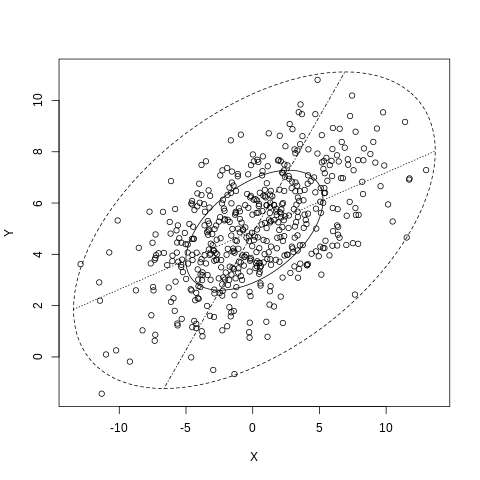

In [124]:
%R bvbox(nv_r, d = 7, method = "robust", xlab = "X", ylab = "Y")

As shown in the plot, the bivariate boxplot accurately summarizes the data from the bivariate normal distribution.

### Example 2.
#### Using the bivariate boxplot to summarize actual data
I wanted to use the second example to demonstrate why it is critical to use visaul exploration methods. In this case, using the bivariate boxplot completely changes our understanding of the relationship between two variables. This evident example was taken from Goldberg and Iglewicz (1992). This article used data from Rousseeuw and Leroy's textbook (1987). For this example, I simply copied the data from the textbook.

The data set includes information about the star cluster in the direction of Cygnus. There are 47 stars in the cluster. We know the logarithm of the effective temperature at the star's surface and the logarithm of its light intensity for each star (Rousseeuw and Leroy, 1987).

Let's first examine the relationship between the variables without using the bivariate boxplot.

In [125]:
# Load data set
stars_df = pd.read_excel('DataSet_Stars.xlsx', index_col='Star_index')
stars_df.head(3)

,Temp_log,Light_intensity_log
Star_index,,
1,4.37,5.23
2,4.56,5.74
3,4.26,4.93


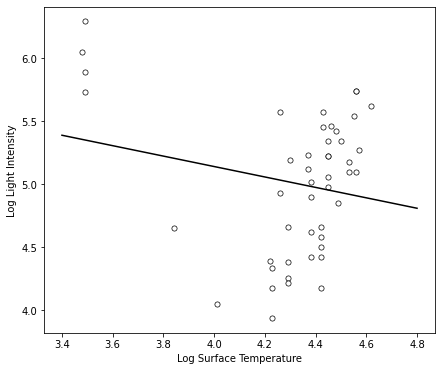

In [126]:
# Plot the relationship between variables
import matplotlib.pyplot as plt

# Fit the regression line
b, a = np.polyfit(stars_df['Temp_log'], stars_df['Light_intensity_log'], deg=1)
x_values = np.linspace(3.4, 4.8, num=10)

plt.figure(figsize=(7,6))
plt.scatter(stars_df['Temp_log'], stars_df['Light_intensity_log'], 
            color='white', s=27, edgecolors='black', linewidths=0.7)
plt.plot(x_values, a + b * x_values, color = 'black')
plt.xlabel('Log Surface Temperature')
plt.ylabel('Log Light Intensity');

A regression line that was constructed using all the data points shows a slight negative relationship between the variables. We got a counter-intuitive result: a star's light intensity decreases as its surface temperature increases.

Now let's examine the data using a bivariate boxplot.

In [127]:
# Convert the pandas dataframe into a R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
     stars_r = ro.conversion.py2rpy(stars_df)

# Create a variable name in R's global environment
ro.globalenv['stars_r'] = stars_r

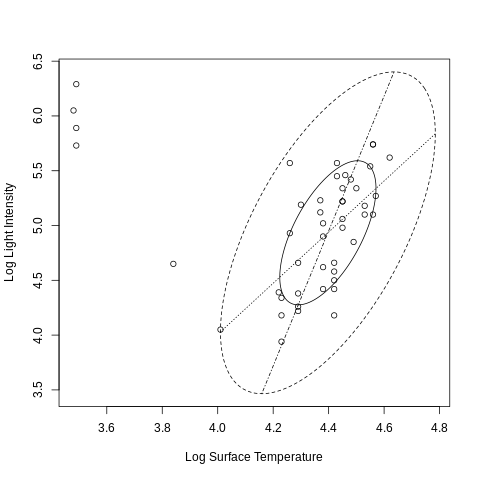

In [129]:
%R bvbox(stars_r, d = 7, method = "robust", \
         xlab = "Log Surface Temperature", ylab = "Log Light Intensity")

The bivariate boxplot exhibits five outliers. Without taking them into account, it is clear that there is a strong positive relationship between the variables: A star's light intensity increases with its surface temperature. The previous plot, however, demonstrated a slight negative relationship. So, the bivariate boxplot can significantly change how we understand data.

### Example 3.
#### Using the bivariate boxplot to summarize actual data. The bivariate boxplot fails to accurately depict the data's characteristics.
In this example the bivariate boxplot was used to investigate the relationship between mortality and exposure to PM2.5 fine particles, small particles that can cause serious health problems if inhaled.

Because it is impossible to have a negative mortality rate, the data is asymmetric. The bivariate boxplot is unable to handle this asymmetry and indicates that negative mortality values are possible.

The data was downloaded in CSV format from the website https://www.oecd-ilibrary.org/environment/data/oecd-environment-statistics_env-data-en.

First, load mortality data from the file 'EXP_MOR.csv'. 

This file contains data on mortality from exposure to air pollution for OECD countries. When I loaded the data, I chose the risk "Ambient particulate matter".

In [130]:
mortality_df = pd.read_csv('EXP_MOR.csv')
# Filter the dataframe: VAR = 'MOR_CAP' (Premature deaths, per million inhabitants), 
# AGE = 'All', SEX = 'BOTH'
mortality_df_filt = mortality_df[(mortality_df['VAR']=='MOR_CAP')\
                                 &(mortality_df['AGE']=='ALL')\
                                 &(mortality_df['SEX']=='BOTH')]
columns = ['COU', 'Country', 'Value']
mortality_df_filt = mortality_df_filt[columns]
mortality_df_filt.rename({'Value': 'Mortality'}, axis='columns', inplace = True)
mortality_df_filt = mortality_df_filt.set_index('COU')
mortality_df_filt.head(4)

,Country,Mortality
COU,,
AUS,Australia,70.732
AUT,Austria,267.220
BEL,Belgium,302.814
CAN,Canada,100.683


In [131]:
mortality_df_filt.describe()

,Mortality
count,38.000000
mean,288.947684
std,192.074275
min,45.837000
25%,145.923500
50%,263.392000
75%,404.881250
max,732.817000


Load data on PM2.5 particle exposure from the file 'EXP PM2 5.csv'. This file contains data for more countries than the previous file.

Variable: Mean population exposure to PM2.5.
Unit: Micrograms per cubic metre.

In [132]:
exposure_df = pd.read_csv('EXP_PM2_5.csv')
exposure_df_filt = exposure_df[columns]
exposure_df_filt = exposure_df_filt.set_index('COU')
exposure_df_filt.rename({'Value': 'Exposure'}, axis='columns', inplace = True)
exposure_df_filt.head(4)

,Country,Exposure
COU,,
AUS,Australia,6.74870
AUT,Austria,12.22494
BEL,Belgium,12.72630
CAN,Canada,7.09026


In [133]:
# Merge dataframes
air_pollution = pd.merge(exposure_df_filt, mortality_df_filt, how='inner')

In [134]:
# Convert the pandas dataframe into a R dataframe
with localconverter(ro.default_converter + pandas2ri.converter):
     air_pollution_r = ro.conversion.py2rpy(air_pollution[['Exposure', 'Mortality']])

# Create a variable name in R's global environment
ro.globalenv['air_pollution_r'] = air_pollution_r

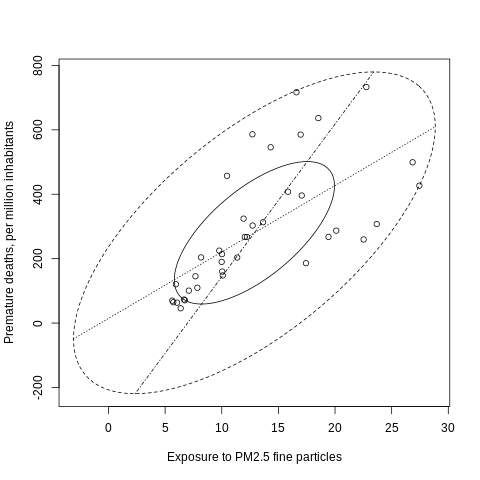

In [136]:
%R bvbox(air_pollution_r, d = 7, method = "robust", xlab = "Exposure to PM2.5 fine particles", \
         ylab = "Premature deaths, per million inhabitants")

The bivariate boxplot showed no outliers. As previously stated, for this example the bivariate boxplot incorrectly describes destribution characteristics. According to the plot, negative mortality is possible, with up to -200 premature deaths per million inhabitant.

Quelplot is a better choice in this case. However, R does not support it. Another option is to use a bagplot, which is better suited to dealing with asymmetry. 

A brief description of the bagplot is provided in Wilcox's textbook (2022): "The bagplot ... provides a more flexible approach to dealing with any asymmetry in the data cloud. Roughly, using some measure of depth, it determines the convex hull containing the deepest half of the data, called the bag. Then this bag is inflated by a factor of 3 relative to the median, and the data points outside of the inflated bag are flagged as outliers."

The bagplot for the analyzed data is shown below:

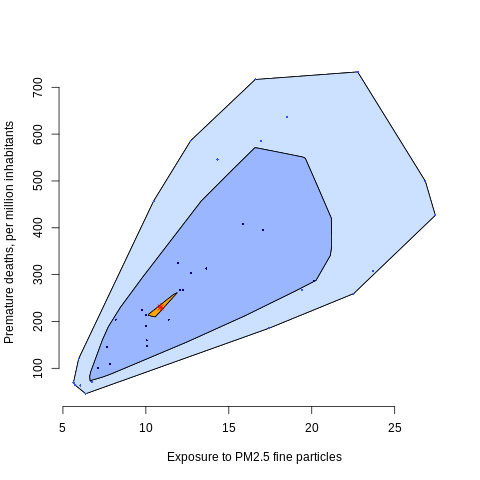

In [137]:
%%R 
bagplot(air_pollution_r['Exposure'], air_pollution_r['Mortality'], 
        xlab="Exposure to PM2.5 fine particles", 
        ylab="Premature deaths, per million inhabitants",
        transparency = TRUE,
        show.whiskers = FALSE)

## **Other reasons to use rpy2**
Thanks to the rpy2 package, we can easily combine the functionality of Python and R in one environment, eliminating the need to load data into R from Python and vice versa. 

R is worth incorporating into the work of a data scientist because it provides cutting-edge statistical techniques, such as modern robust methods, that enable a more precise and complex understanding of data. Of course, Python has some of the modern methods, like in scikit-learn, but the number of them is much smaller than what R can offer. For instance, I was unable to find in Python the multivariate trimmed mean, a measure of location that is resistant to outliers.

## **References**

*   Everitt, B.S. (2005). An R and S-PLUS Companion to Multivariate Analysis. Springer.
*   Kenneth M. Goldberg, K.M. Iglewicz, B. (1992). Bivariate Extensions of the Boxplot. Technometrics, 34(3), pp. 307-320.
*   Rousseeuw,P.J., Leroy, A.M. (1987). Robust Regression and Outlier Detection. John Wiley & Sons, Inc.
*   Wilcox, R.R. (2022). Introduction to Robust Estimation and Hypothesis
Testing (5th ed.). Elsevier Inc.
*   rpy2 3.5.4 documentation, Requirements, https://rpy2.github.io/doc/v3.5.x/html/overview.html#requirements
*   rpy2 3.5.4 documentation, Using rpy2 in notebooks, https://rpy2.github.io/doc/v3.4.x/html/generated_rst/notebooks.html
*   rpy2 3.5.4 documentation, R and pandas data frames, https://rpy2.github.io/doc/latest/html/generated_rst/pandas.html
*   rpy2 3.5.4 documentation, Interactive work, https://rpy2.github.io/doc/latest/html/interactive.html
*   rpy2 3.5.4 documentation, Environments, https://rpy2.github.io/doc/latest/html/robjects_environments.html
*   https://www.oecd-ilibrary.org/environment/data/oecd-environment-statistics_env-data-en
*   https://stackoverflow.com/questions/74283327/conversion-py2rpy-not-defined-for-objects-of-type-class-str/74414817




